## Fitting models the right way

In the previous chapter we learnt abour regression, and the problems that arise when you try and fit models which are overly complex, especially when you have less data.

In this chapter we will learn about how this overfitting can be combatted. We will learn two techniques: Validation, which attempts to directly estimate the out of sample error or risk, and Regularization, which attempts to penalize overly complex functions or hypotheses in the in-sample error.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot23():
    fig, axes=plt.subplots(figsize=(12,5), nrows=2, ncols=3);
    axes[0][0].set_ylim([-2,2])
    axes[0][1].set_ylim([-2,2])
    axes[0][2].set_ylim([-2,2])
    axes[1][0].set_ylim([-2,2])
    axes[1][1].set_ylim([-2,2])
    axes[1][2].set_ylim([-2,2])
    axes[0][0].set_ylabel("$y$")
    axes[1][0].set_ylabel("$y$")
    axes[1][0].set_xlabel("$x$")
    axes[1][1].set_xlabel("$x$")
    axes[1][2].set_xlabel("$x$")
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(15,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    plt.tight_layout();
    return axes

###The Out-Of-Sample Risk

As we saw in the last chapter, the process of learning has two parts:

1. Fit for a model by minimizing the in-sample risk
2. Hope that the in-sample risk approximates the out-of-sample risk well.

Well, we are scientists. Just hoping does not befit us. But we only have a sample. What are we to do?

The "aha" moment comes when we realize that we can hold back some of our sample, and test the performance of our learner by trying it out on this held back part! Perhaps we can compute the error or risk on the held-out part, or "test" part of our sample, and have something to say about the out-of-sample error.

####Testing and Training Sets

Let us introduce some new terminology. We take the sample of data $\cal{D}$ that we have been given (our in-sample set) and split it into two parts:

1. The **training set**, which is the part of the data we use to fit a model
2. The **testing set**, a smaller part of the data set which we use to see how good our fit was.

This split is done by choosing points at random into these two sets. Typically we might take 80% of our data and put it in the training set, with the remaining amount going into the test set. This can be carried out in python using the `train_test_split` function from `sklearn.cross_validation`.

The split is shown in the diagram below:

![m:caption](images/bookimages/train-test.png)

We ARE taking a hit on the amount of data we have to train our model. The more data we have, the better we can do for our fits. But, you cannot figure out the generalization ability of a learner by looking at the same data it was trained on: there is nothing to generalize to, and as we know we can fit very complex models to training data which have no hope of generalizing (like an interpolator). Thus, to estimate the **out-of-sample error or risk**, we must leave data over to make this estimation. 

At this point you are thinking: the test set is just another sample of the population, just like the training set. What guarantee do we have that it approximates the out-of-sample error well? And furthermore, if we pick 6 out of 30 points as a test set, why would you expect the estimate to be any good?

Its not possible to prove it now, but we shall show in chapter REF that the test set error is a good estimate of the out of sample error, especially for larger and larger test sets. You are right to worry that 6 points is perhaps too few, but thats what we have for now, and we shall work with them.

We are **using the training set then, as our in-sample set, and the test set as a proxy for out-of-sample.**.

In [3]:
df=pd.read_csv("romneysamples.csv")
df.head()

,f,x,y
0,0.080757,0.08,0.147024
1,0.121673,0.15,0.105355
2,0.135666,0.17,0.110000
3,0.211855,0.26,0.225779
4,0.263258,0.31,0.168969


The data set has the values of `x`, the fraction of voters in a county who are religious, the `y`, the fraction who have said in polls that they will vote for Romney. Also given to us if `f`, the "true" fraction of voters who will vote for Romney. Remember that in reality we never know `f`. But since we set up this problem as a toy problem, we have this additional information and can see how our models do against `f`. `y` is a noisy version of `f`, with the noise coming in from polling error as well as hidden variables such as race which might affect the voting patterns of religious voters.

We split the data set 80-20 at random below and plot it. The left panel shows the dataset $\cal{D}$ and the function $f$ (which we "dont know"). The right panel shows the 30 data points in $\cal{D}$ split into 24 training points and 6 test points as described above.

In [117]:
from sklearn.cross_validation import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(datasize),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

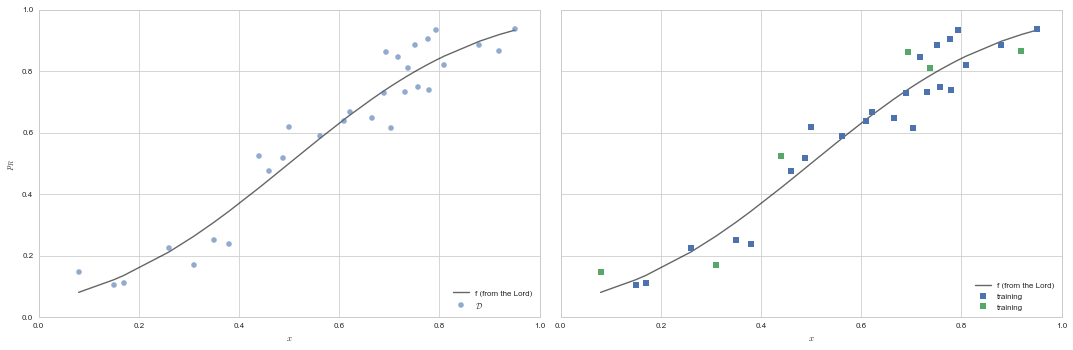

In [118]:
axes=make_plot()
axes[0].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(df.x,df.y, 'o',alpha=0.6, label="$\cal{D}$");
axes[1].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[1].plot(xtrain, ytrain, 's', label="training")
axes[1].plot(xtest, ytest, 's', label="training")
axes[0].legend(loc="lower right")
axes[1].legend(loc="lower right")

####A short digression about scikit-learn

Scikit-learn is the main python machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in python by the incantation `import sklearn`.

The library has a very well defined interface. This makes the library a joy to use, and surely contributes to its popularity. As the [scikit-learn API paper](http://arxiv.org/pdf/1309.0238v1.pdf) [REF] says:

>All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: an estimator interface for building and ﬁtting models, a predictor interface for making predictions and a transformer interface for converting data. The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators.

In the last chapter we fit `y` using the python function `polyfit`. To get you familiarized with scikit-learn, we'll use the "estimator" interface here, specifically the estimator `PolynomialFeatures`. The API paper[REF] again:

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a transformer interface which deﬁnes a transform method. It takes as input some new data X and yields as output a transformed version of X. Preprocessing, feature selection, feature extraction and dimensionality reduction algorithms are all provided as transformers within the library.

To start with we have one **feature** `x`, the fraction of religious people in a county, which we want to use to predict `y`, the fraction of people voting for Romney in that county. What we will do is the transformation:

$$ x \rightarrow x, x^2, x^3, ..., x^d $$

for some power $d$. Our job then is to **fit** for the coefficients of these features in the polynomial

$$ a_0 + a_1 x + a_2 x^2 + ... + a_d x^d. $$

In other words, we have transformed a function of one feature, into a (rather simple) **linear** function of many features. To do this we first construct the estimator as `PolynomialFeatures(d)`, and then transform these features into a d-dimensional space using the method `fit_transform`.

For example:

In [119]:
from sklearn.preprocessing import PolynomialFeatures
PolynomialFeatures(3).fit_transform([[1],[2], [3]])

array([[ 1,  1,  1,  1],
       [ 1,  2,  4,  8],
       [ 1,  3,  9, 27]])

The reason for using `[[1],[2],[3]]` as opposed to `[1,2,3]` is that scikit-learn expects data to be stored in a two-dimensional array or matrix with size `[n_samples, n_features]`.

Ok, so lets write a function to transform our 1-D dataset `x` into a d-dimensional one.

In [120]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

###How do training and testing error change with complexity?

You will recall that the big question we were left with from the previous chapter is: what order of polynomial should we use to fit the data? Which order is too biased? Which one has too much variance and is too complex? Let us try and answer this question.

We do this by fitting 14 different models (remember the fit is made by minimizing the empirical risk on the training set), each with increasing dimension `d`, and looking at the training-error and the test-error in each of these models. So we first try $\cal{H}_0$, then $\cal{H}_1$, then $\cal{H}_2$, and so on.

Since we use `PolynomialFeatures` above, each increasing dimension gives us an additional feature. $\cal{H}_5$ has 6 features, a constant and the 5 powers of `x`. What we want to do is to find the coefficients of the 5-th order polynomial that best fits the data. Since the polynomial is **linear** in the features, we use a learner called a `LinearRegression` model. The scikit-learn interface to make such a fit is also very simple, the function `fit`. And once we have learned a model, we can predict using the function `predict`. The API paper again[REF]:

>The predictor interface extends the notion of an estimator by adding a predict method that takes an array X_test and produces predictions for X_test, based on the learned parameters of the estimator.

So, for increasing polynomial degree, and thus feature dimension `d`, we fit a `LinearRegression` model on the traing set. We then use scikit-learn again to calculate the error or risk. We calculate the `mean_squared_error` between the model's predictions and the data, BOTH on the training set and test set. We plot this error as a function of the defree of the polynomial `d`.

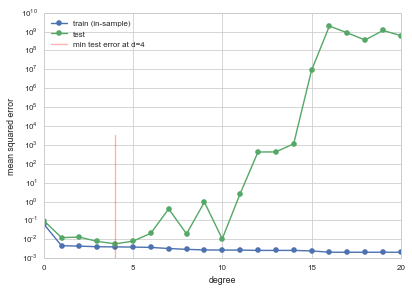

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees=range(21)
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

traintestlists=make_features(xtrain, xtest, degrees)
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    est = LinearRegression()
    est.fit(Xtrain, ytrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, est.predict(Xtrain))
    error_test[d] = mean_squared_error(ytest, est.predict(Xtest))

plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(np.argmin(error_test), 0,0.5, color='r', label="min test error at d=%d"%np.argmin(error_test), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

The graph shows a very interesting structure. The training error decreases with increasing degree of the polynomial. This ought to make sense given what you know now: one can construct an arbitrarily complex polynomial to fit all the training data: indeed one could construct an order 24 polynomial which perfectly interpolates the 24 data points in the training set. You also know that this would do very badly on the test set as it would wiggle like mad to capture all the data points. And this is indeed what we see in the test set error. 

For extremely low degree polynomials like $d=0$ a flat line capturing the mean value of the data or $d=1$ a straight line fitting the data, the polynomial is not curvy enough to capturve the conbtours of the data. We are in the bias/deterministic error regime, where we will always have some difference between the data and the fit since the hypothesis is too simple. But, for degrees higher than 4, the polynomial starts to wiggle too much to capture the training data. The test set error increases as the predictive power of the polynomial goes down thanks to the contortions it must endure to fit the training data.

Thus the test set error first decreases as the model get more expressive, and then, once we exceed a certain level of complexity (here indexed by $d$), it increases. This idea can be used to identify just the right amount of complexity in the model by picking as **the best hypothesis as the one that minimizes test set error** or risk. In our case this happens at $d=4$. (This exact number will depend on the random points chosen into the training and test sets) For complexity lower than this critical value, identified by the red vertical line in the diagram, the hypotheses underfit; for complexity higher, they overfit.

![m:caption](images/bookimages/complexity-error-plot.png)

###Validation

There is a problem with the process above which is not apparent at first look. What we have done in picking $d=4$ as the best hypothesis is that we have used the test set as a training set. How?

Our process used the training set to fit for the **parameters**(values of the coefficients) of the polynomial of given degree $d$ based on minimizing the traing set error (empirical risk minimization). We then calculated the error on the test set at that $d$. If we go further and choose the best $d$ based on minimizing the test set error, we have then "fit for" $d$ on the test set. We will thus call $d$ a **hyperparameter** of the model.

In this case, the test-set error will underestimate the true out-of-sample error, even as the test set size is made larger (we shall show this in chapter REF). Furthermore, we have "contaminated" the test set by fitting for $d$ on it; it is no longer a true test set.

Thus, we must introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](images/bookimages/train-validate-test.png)

We have split the old training set into a training set and a validation set, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ through the test risk $\cal{E}_{test}$.

####The validation process

![m:caption](images/bookimages/train-validate-test-cont.png)

The validation process is illustrated in these two figures. We first loop ober all the hypothesis sets that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](images/bookimages/train-validate-test3.png)

Having picked the hyperparameter $d_*$, we retrain using the hypothesis set $\cal{H}_{*}$ on the entire old training-set to find the parameters of the polynomial of order $d_*$ and the corresponding best fit hypothesis $g_*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E}_{test}$.

Thus the **validation** set if the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

4


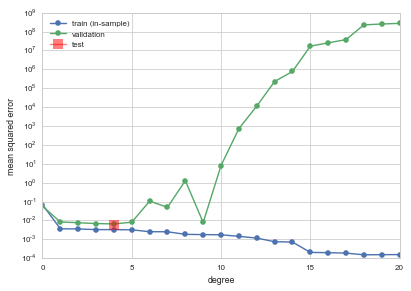

In [123]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid) 
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print mindeg

We obtained a validation set minimizing polynomial degree of 4.

Lets do this again, choosing a new random split between training and validation data: 

1


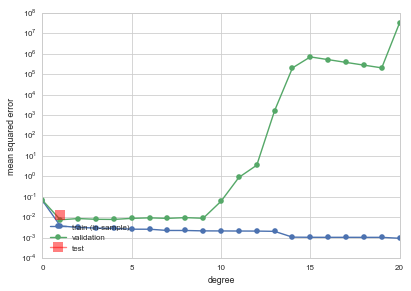

In [124]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid)
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='lower left')
plt.yscale("log")
print mindeg

This time the validation error minimizing polynomial degree changed! What happened?

###Cross Validation

Remember that we chose a new random split? Since we are dealing with small data sizes here, you should worry that this exposes us to the peciliarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.

Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible.

But the smaller the validation set is, the more data we have to train ourmodel on. Thus we can fit a better, more expressive model.

We want to balance these two desires, and additionally, not be exposed to any peculiarities that might randomly arise in any single train-validate split of the old training set.

To deal with this we engage in a process called **cross-validation**, which is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denotet as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/bookimages/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

In [125]:
f = lambda x: np.sin(np.pi*x)
D=np.empty((100,3), dtype="int")
print D.shape
for i in range(100):
    D[i,:] = np.random.choice(200, replace=False, size=3)
xs=np.arange(-1.,1.,0.01)
fxs=f(xs)

(100, 3)


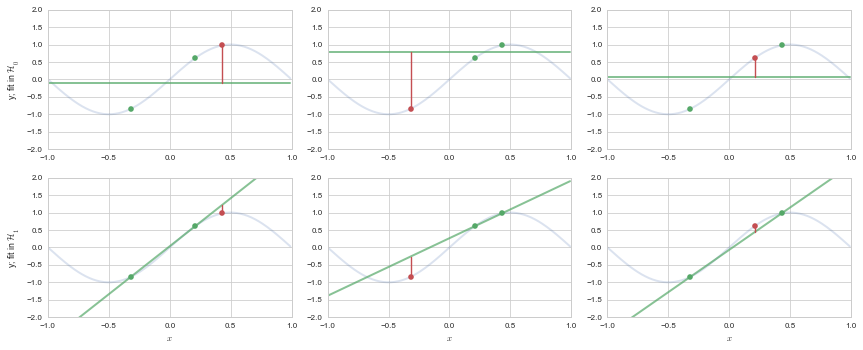

In [126]:
axes23=make_plot23()
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

#axes[1].plot(xs, f(xs), alpha=0.5, lw=2, color=c0)
choices = D[45,:]
for i, ptsa in enumerate([[0,1,2], [1,2,0], [0,2,1]]):
    pts=ptsa[:-1]
    other=[ptsa[-1]]
    axes23[0][i].plot(xs, f(xs), alpha=0.2, lw=2, color=c0)
    axes23[1][i].plot(xs, f(xs), alpha=0.2, lw=2, color=c0)
    p0=np.polyfit(xs[choices[pts]], fxs[choices[pts]],0)
    p1=np.polyfit(xs[choices[pts]], fxs[choices[pts]],1)
    p0val=np.polyval(p0, xs)
    p1val=np.polyval(p1, xs)
    axes23[0][i].plot(xs, p0val, color=c1, alpha=0.7, lw=2)
    axes23[1][i].plot(xs, p1val, color=c1, alpha=0.7, lw=2)
    axes23[0][i].plot(xs[choices[other]], fxs[choices[other]], 'o', color=c2)
    axes23[0][i].plot([xs[choices[other]][0],xs[choices[other]][0]], [fxs[choices[other]][0],p0val[choices[other]][0]], color=c2, label="LOOCV error")
    axes23[0][i].plot(xs[choices[pts]], fxs[choices[pts]], 'o', color=c1)
    axes23[1][i].plot(xs[choices[other]], fxs[choices[other]], 'o', color=c2)
    axes23[1][i].plot([xs[choices[other]][0],xs[choices[other]][0]], [fxs[choices[other]][0],p1val[choices[other]][0]], color=c2, label="LOOCV error")
    axes23[1][i].plot(xs[choices[pts]], fxs[choices[pts]], 'o', color=c1)

#axes[1].plot(xs[choices], fxs[choices], 'o', color=c2, alpha=0.9)
axes23[0][0].set_ylabel("y; fit in $\\cal{H_0}$");
axes23[1][0].set_ylabel("y; fit in $\\cal{H_1}$");
#plt.legend();

Let us consider 3-fold Cross Validation. We first leave one point out (marked red in the graph). We then make a fit using the remaining two points. This fit is shown with a green line. Finally we calculate the error from the fit to the third point. We do this for each of the 3-folds and average. The average error is then used to choose a best fit model, here the straight line.

This extreme case, where we consider N splits in the data where N is the size of the old trainingg set, with each fold thus having just one data point in it, is called **Leave-One-Out Cross-validation** (LOOCV). 

####The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions, and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/bookimages/train-cv3.png)

CV unbiased and all that. it can also be shown to be an unbiased estimate of the out of sample-error.

Let us now do 4-fold cross-validation on our Romney votes data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the ramining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

In [127]:
from sklearn.cross_validation import KFold
n_folds=4
degrees=range(21)
results=[]
for d in degrees:
    hypothesisresults=[]
    for train, test in KFold(24, n_folds): # split data into train/test groups, 4 times
        tvlist=make_features(xtrain[train], xtrain[test], degrees)
        clf = LinearRegression()
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test], clf.predict(tvlist[d]['test']))) # evaluate score function on held-out data
    results.append((np.mean(hypothesisresults), np.min(hypothesisresults), np.max(hypothesisresults))) # average

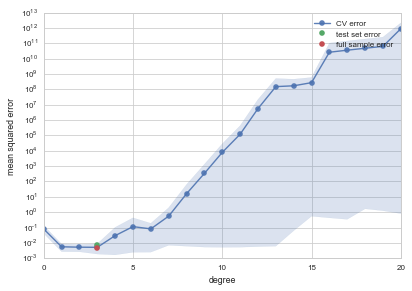

In [128]:
mindeg = np.argmin([r[0] for r in results])
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))
errout=0.8*errtr+0.2*err
c0=sns.color_palette()[0]
#plt.errorbar(degrees, [r[0] for r in results], yerr=[r[1] for r in results], marker='o', label='CV error', alpha=0.5)
plt.plot(degrees, [r[0] for r in results], marker='o', label='CV error', alpha=0.9)
plt.fill_between(degrees, [r[1] for r in results], [r[2] for r in results], color=c0, alpha=0.2)
plt.plot([mindeg], [err], 'o',  label='test set error')
plt.plot([mindeg], [errout], 'o',  label='full sample error')


plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

###Regularization

Upto now we have focussed on finding the polynomial with the right degree of complecity $d=*$ given the data that we have.

Let us now ask a different question: if we are going to fit the data with an expressive model such as 20th order polynomials, how can we **regularize** or smooth or restrict the choices of the kinds of 20th order polynomials that we allow in our fits. In other words, we are again trying to bring down the complexity of the hypothesis space, but by a different tack: a tack which prefers smooth polynomials over wiggly ones.

That is, if we want to fit with a 20th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions in $\cal{H}_{20}$ that we allow.

In a sense we have already done this, havent we? When we compared $\cal{H}_1$ over $\cal{H}_{10}$ in the last chapter, we imposed a **hard constraint** by setting all polynomial co-efficients for terms higher than $x$ to 0. Instead we might want to set a **soft constraint** by setting:

$$\sum_{i=0}^j a_i^2 < C.$$

We can do this by adding a term to the empirical risk that we minimize on the training data for $\cal{H}_j$ (we shall show why this is the case in chapter REF):

$$\cal{R}(h_j) =  \sum_{y_i \in \cal{D}} (y_i - h_j(x_i))^2 +\alpha \sum_{i=0}^j a_i^2.$$

This new risk takes the empirical risk and adds a "penalty term" to it to minimize overfitting. The term is proportional to the sum of the squares of the coefficients and is positive, so it will keep their values down

Notice that we are adding a term to the **training error**, once $\alpha$ is defined. The entire structure is similar to what we did to find the optimal $d=*$, with $\alpha$ being the analog of $d$. And thus we can use the same validation and cross-validation technology that we developed to estimate $d$.

This technique is called **regularization** or **shrinkage** as it takes the coefficients $a_i$ towards smaller sizes. As you have seen in the previous chapter, for polynomials this corresponds to choosing smooth functions over wiggly functions. When $\alpha=0$ we have the regular polynomial regression problem, and if we are using 20th order polynomials we will wildly overfit. We are in the high variance zone. The problem with a non-zero $\alpha$ is called **ridge regression**. As $\alpha$ increases, the importance of the penalty term increases at the expense of the ERM term, and we are pushed to increase the smoothness of the polynomials. When $\alpha$ becomes very large the penalty term dominates and we get into the high bias zone. Thus $\alpha$ acts as a complexity parameter just like $d$ did, with high complexity being $\alpha \to 0$.

Let us illustrate the concept of regularization using the example of the sine wave. This time we shall consider fits using the straight lines in $\cal{H}_1$. Once again we fit a straight line to 3 points, choosing 100 such set of 3 points from the data set.

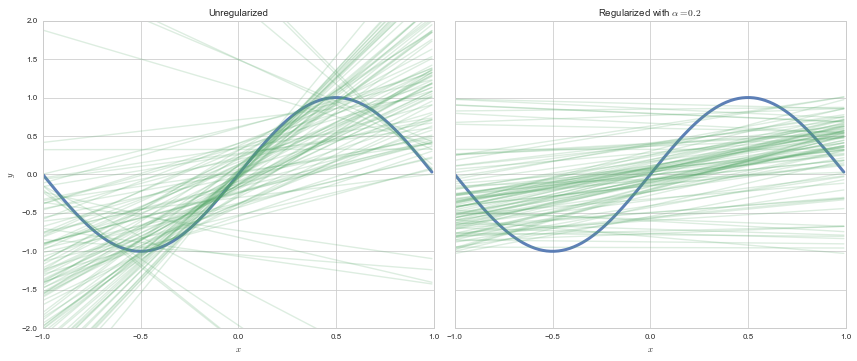

In [129]:
from sklearn.linear_model import Ridge
axes=make_simple_plot()
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
axes[0].plot(xs, f(xs), alpha=0.9, lw=3, color=c0)
axes[1].plot(xs, f(xs), alpha=0.9, lw=3, color=c0)
from sklearn.linear_model import Ridge
for i in range(100):
    choices = D[i,:]
    p1=np.polyfit(xs[choices], fxs[choices],1)
    est = Ridge(alpha=1.0)
    est.fit(xs[choices].reshape(-1,1), fxs[choices])
    axes[0].plot(xs, np.polyval(p1, xs), color=c1, alpha=0.2)
    axes[1].plot(xs, est.predict(xs.reshape(-1,1)), color=c1, alpha=0.2)
axes[0].set_title("Unregularized");
axes[1].set_title("Regularized with $\\alpha=1.0$");

In the left panel we plot unregularized straight line fits. The plot is hairy, since choosing 3 points from 200 between -1 and 1 dosent constrain the lines much at all. On the right panel, we plot the output of **Ridge** regression with $\alpha=1$. This corresponds to adding a term to the empirical risk of $\alpha\, (a_0^2 + a_1^2)$ where $a_0$ and $a_1$ are the intercept and slope of the line respectively. Notice that the lines are much more constrained  in this second plot. The penalty term has regularized the values of the intercept and slope, and forced the intercept to be closer to 0 and the lines to be flatter.

In [130]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    

In [152]:
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

###Regularization of the Romney model with Cross-Validation

Lets now go back to the Romney voting model and see what regularization does to the fits in that model. The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{20}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 20th order polynomials indexed by $\alpha_*$.

![m:caption](images/bookimages/complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

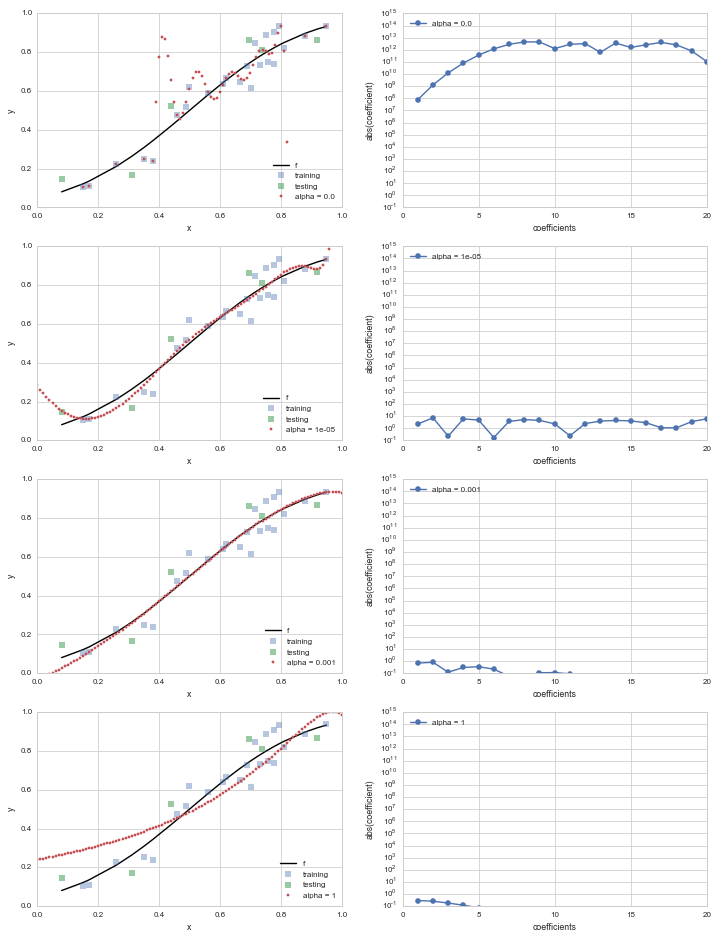

In [153]:
fig, rows = plt.subplots(4, 2, figsize=(12, 16))
d=20
alphas = [0.0, 1e-5, 1e-3, 1]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as we increase $\alpha$ from 0 to 1, we start out overfitting, then doing well, and then, our fits, develop a mind of their own irrespective of data, as the penalty term dominates the risk.

Lets use cross-validation to figure what this critical $\alpha_*$ is. To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper[REF] puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(clf, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doint it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $\alpha$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $\alpha$'s, and picks the best choice model.

In [135]:
from sklearn.metrics import make_scorer
#, 1e-6, 1e-5, 1e-3, 1.0
from sklearn.grid_search import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [136]:
#stick with d=20
bestmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)

In [137]:
bestmodel.best_estimator_, bestmodel.best_params_, bestmodel.best_score_, bestmodel.grid_scores_

(Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, solver='auto', tol=0.001),
 {'alpha': 0.01},
 -0.007518160297738768,
 [mean: -98.98295, std: 171.41333, params: {'alpha': 1e-08},
  mean: -0.06923, std: 0.10805, params: {'alpha': 1e-06},
  mean: -0.02890, std: 0.04100, params: {'alpha': 1e-05},
  mean: -0.21085, std: 0.35635, params: {'alpha': 5e-05},
  mean: -0.22819, std: 0.38635, params: {'alpha': 0.0001},
  mean: -0.10905, std: 0.17998, params: {'alpha': 0.0005},
  mean: -0.06382, std: 0.10168, params: {'alpha': 0.001},
  mean: -0.00752, std: 0.00479, params: {'alpha': 0.01},
  mean: -0.00777, std: 0.00246, params: {'alpha': 0.1},
  mean: -0.01952, std: 0.00602, params: {'alpha': 1.0}])

Our best model occurs for $\alpha=0.01$. We also output the mean cross-validation error at different $\alpha$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

We refit the estimator on old training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.

In [138]:
alphawechoose = bestmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [139]:
err=mean_squared_error(clf.predict(Xtest), ytest)
errtr=mean_squared_error(clf.predict(Xtrain), ytrain)
errout=0.8*errtr+0.2*err

In [141]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

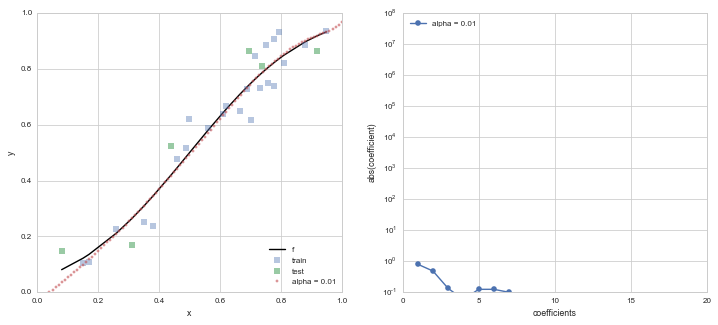

In [142]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)

As we can see, the best fit model is now chosen from the entire set of 20th order polynomials, ans a non-zero hyperparameter $\alpha$ that we fit for ensures that only smooth models amonst these polynomials are chosen, by setting most of the polynomial coefficients to 0. We can plot some of the results for other alphas to see what the results there look like:

####What is minimized where?

Regularization adds a term to the error or risk, which is then, for fixe $\alpha$, minimized on the training set.
The validation error is then calculated on the validation set and reported alongside the value of $\alpha$ used. If we cross-validate, then the validation error is an average over multiple folds.

On the other hand, when we validate for $d$, we use the validation as an estimate of the out-of-sample error and use this estimate to directly pick the best model (best $d$).

One can think of **regularization as an estimation of the overfit term** while **validation directly estimates $R_{out}$**.